In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter

from VQ_VAE_2 import VVQModel

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import umap

from scipy.signal import savgol_filter

import sys

In [2]:
# download and transform train dataset
train_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

train_dataloader = torch.utils.data.DataLoader(train_data, 
                             batch_size=256, 
                             shuffle=True,
                             pin_memory=True)

# download and transform test dataset
test_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

test_dataloader = torch.utils.data.DataLoader(test_data,
                               batch_size=64,
                               shuffle=True,
                               pin_memory=True)

14.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

38.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

58.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

81.1%IOPub

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [9]:
"""
HYPERPARAMETERS
"""
bottom_num_embeddings = 512
bottom_embedding_dim = 16**2

middle_num_embeddings = 512
middle_embedding_dim = 4**2

num_epochs = 300
epochs_trained = 0
learning_rate = 3e-4

beta = .25
"""
HYPERPARAMETERS
"""

model =  nn.DataParallel(VVQModel(

    bottom_num_embeddings=bottom_num_embeddings, 
    bottom_embedding_dim=bottom_embedding_dim,
    middle_num_embeddings=middle_num_embeddings,
    middle_embedding_dim=middle_embedding_dim,
    beta = beta
    
 ), device_ids=[0, 1, 2, 3]).cuda()

train_res_recon_error = []
train_res_perplexity = []

writer = SummaryWriter()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
data_variance = np.var(train_data.data / 255.0)

In [ ]:
for epoch in range(epochs_trained, num_epochs):

    epoch_recon_error = 0
    epoch_perplexity_error = 0
    
    model.train()
    
    for batch, _ in train_dataloader:
        
        batch = batch.to(torch.device('cuda'))
        optimizer.zero_grad()
        
        vq_loss, data_reconstructed, perplexity = model(batch)

        # TODO Take the mean of vq_loss?
        reconstructed_error = F.mse_loss(data_reconstructed, batch) / data_variance
        loss = reconstructed_error + vq_loss
        loss.sum().backward()
        optimizer.step()

        epoch_recon_error += reconstructed_error.item()
        epoch_perplexity_error += perplexity.sum(dim=0).item()
        
        
    epoch_recon_error = epoch_recon_error / len(train_dataloader.dataset)
    epoch_perplexity_error = epoch_perplexity_error / len(train_dataloader.dataset)
    
    writer.add_scalar('Training Reconstruction Loss', epoch_recon_error, epoch)
    writer.add_scalar('Training Perplexity', epoch_perplexity_error, epoch)
    
    train_res_recon_error.append(epoch_recon_error)
    train_res_perplexity.append(epoch_perplexity_error)

    sys.stdout.write('\rEpoch- %d' % (epoch + 1))

Epoch- 5

Text(0.5, 1.0, 'Reconstructed Input')

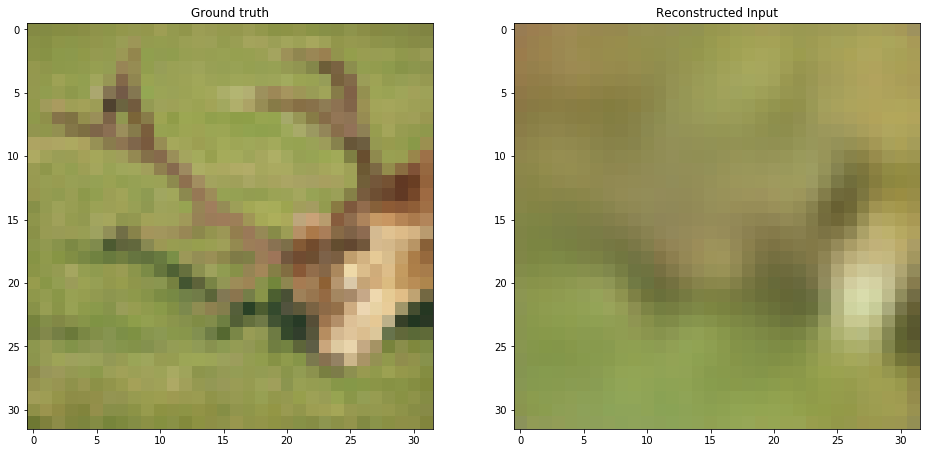

In [18]:
model.eval()
(data, _) = next(iter(test_dataloader))
data = data.to(torch.device('cuda'))

_, reconstructed_data, _ = model(data)
#for _ in range(100):
#    _, reconstructed_data, _ = model(reconstructed_data)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ground_truth = np.transpose((data[0].cpu().data + 0.5), (1, 2, 0))
ax.imshow(ground_truth)
ax.set_title('Ground truth')

ax = f.add_subplot(1,2,2)
reconstructed = np.transpose(reconstructed_data[0].cpu().data + 0.5, (1, 2, 0))
ax.imshow(reconstructed)
ax.set_title('Reconstructed Input')

Text(0.5, 1.0, 'Reconstructed Input')

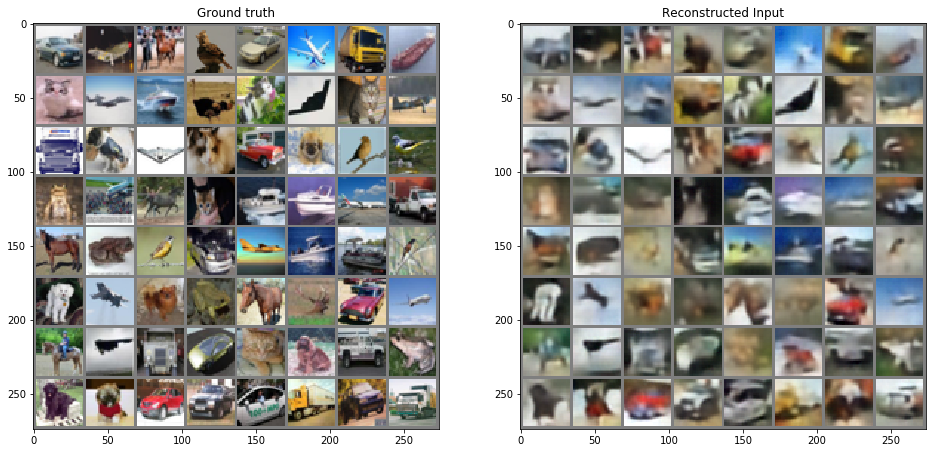

In [9]:
model.eval()
(data, _) = next(iter(test_dataloader))
data = data.to(torch.device('cuda'))

_, reconstructed_data, _ = model(data)
#for _ in range(100):
#    _, reconstructed_data, _ = model(reconstructed_data)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ground_truth = np.transpose((make_grid(data.cpu().data) + 0.5), (1, 2, 0))
ax.imshow(ground_truth)
ax.set_title('Ground truth')

ax = f.add_subplot(1,2,2)
reconstructed = np.transpose((make_grid(reconstructed_data.cpu().data) + 0.5), (1, 2, 0))
ax.imshow(reconstructed)
ax.set_title('Reconstructed Input')

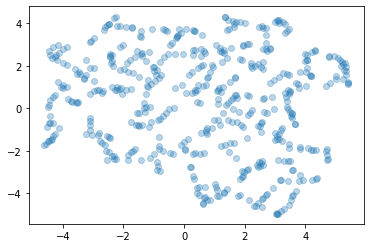

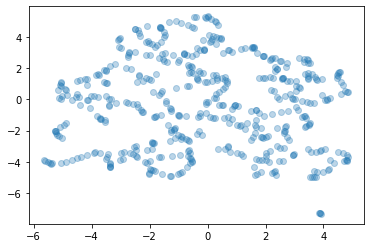

In [5]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model.module.encoder.bottom_quantizer._embedding.weight.data.cpu())

plt.scatter(proj[:,0], proj[:,1], alpha=0.3)
plt.show()

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model.module.encoder.middle_quantizer._embedding.weight.data.cpu())

plt.scatter(proj[:,0], proj[:,1], alpha=0.3)
plt.show()

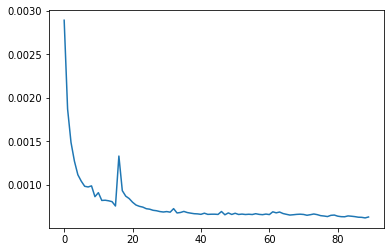

In [6]:
plt.plot(train_res_recon_error)
plt.show()